<a href="https://colab.research.google.com/github/gnavya000/Gowri-Navya-Ponamala/blob/main/Copy_of_Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving True.csv to True.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake.csv


In [ ]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")


In [ ]:
print("True.csv shape:", df_true.shape)
print("Fake.csv shape:", df_fake.shape)

True.csv shape: (21417, 4)
Fake.csv shape: (23481, 4)


In [ ]:
df_true['label'] = 'REAL'
df_fake['label'] = 'FAKE'
df = pd.concat([df_true, df_fake], ignore_index=True)

df['content'] = df['title'] + " " + df['text']
df = df[['content','label']]

print("Combined shape:", df.shape)
print(df['label'].value_counts())
df.head()

Combined shape: (44898, 2)
label
FAKE    23481
REAL    21417
Name: count, dtype: int64


,content,label
0,"As U.S. budget fight looms, Republicans flip t...",REAL
1,U.S. military to accept transgender recruits o...,REAL
2,Senior U.S. Republican senator: 'Let Mr. Muell...,REAL
3,FBI Russia probe helped by Australian diplomat...,REAL
4,Trump wants Postal Service to charge 'much mor...,REAL


In [ ]:
print("Nulls per column:\n", df.isnull().sum())

Nulls per column:
 content    0
label      0
dtype: int64


In [ ]:
lengths = df['content'].str.len()
print("\nLength stats:\n", lengths.describe())


Length stats:
 count    44898.000000
mean      2550.221413
std       2172.578772
min         31.000000
25%       1318.000000
50%       2270.000000
75%       3189.000000
max      51893.000000
Name: content, dtype: float64


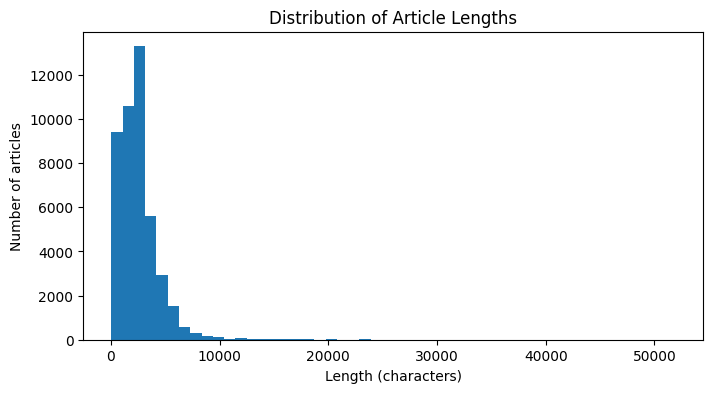

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(lengths, bins=50)
plt.title("Distribution of Article Lengths")
plt.xlabel("Length (characters)")
plt.ylabel("Number of articles")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

In [ ]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
X_tfidf = tfidf.fit_transform(df['content'])
y = df['label'].map({'REAL':0,'FAKE':1})

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (44898, 40260)


In [ ]:

selector = SelectKBest(chi2, k=10000)
X_sel = selector.fit_transform(X_tfidf, y)
print("Selected features shape:", X_sel.shape)

Selected features shape: (44898, 10000)


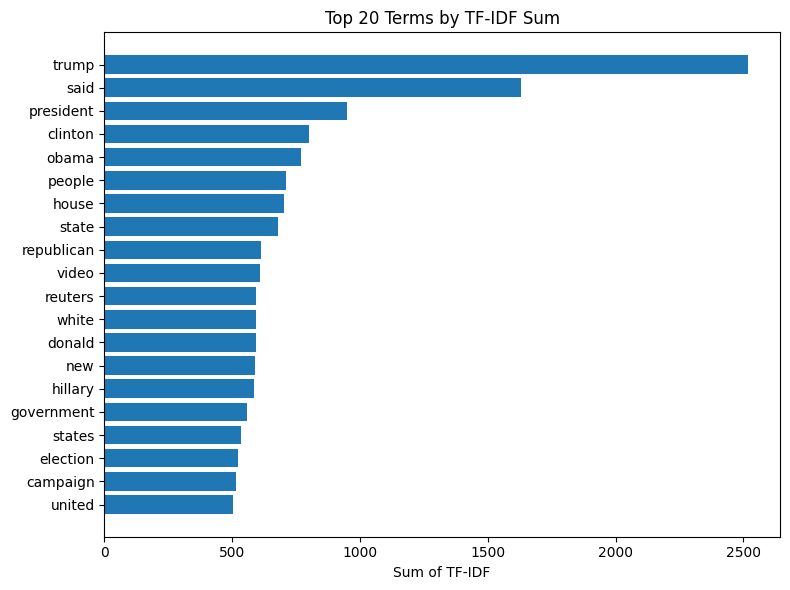

In [ ]:
import numpy as np

# Sum TF-IDF weights and finding top 20 terms

term_sums = np.array(X_tfidf.sum(axis=0)).ravel()
terms = tfidf.get_feature_names_out()
top20_idx = np.argsort(term_sums)[-20:]
top_terms = terms[top20_idx]
top_vals = term_sums[top20_idx]

plt.figure(figsize=(8,6))
plt.barh(top_terms, top_vals)
plt.title("Top 20 Terms by TF-IDF Sum")
plt.xlabel("Sum of TF-IDF")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_text = df['content']
y = df['label'].map({'REAL':0,'FAKE':1})

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2,
    random_state=42, stratify=y
)
print("Train:", X_train_text.shape[0], "Test:", X_test_text.shape[0])

Train: 35918 Test: 8980


In [ ]:
tfidf_nb = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

X_train_nb = tfidf_nb.fit_transform(X_train_text)
X_test_nb  = tfidf_nb.transform(X_test_text)

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_nb, y_train)
y_nb = nb.predict(X_test_nb)

from sklearn.metrics import classification_report, confusion_matrix

print("NB Report:\n", classification_report(y_test, y_nb, target_names=['REAL','FAKE']))
print("NB Confusion:\n", confusion_matrix(y_test, y_nb))


NB Report:
               precision    recall  f1-score   support

        REAL       0.94      0.94      0.94      4284
        FAKE       0.94      0.94      0.94      4696

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

NB Confusion:
 [[4014  270]
 [ 265 4431]]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# Fitting TF-IDF on train text only
tfidf = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

# Fitting chi selector on train, applying to both

selector = SelectKBest(chi2, k=10000)
X_train_sel = selector.fit_transform(X_train_tfidf, y_train)
X_test_sel  = selector.transform(X_test_tfidf)

print("Train TF-IDF → Selected:", X_train_sel.shape)
print("Test  TF-IDF → Selected:", X_test_sel.shape)


Train TF-IDF → Selected: (35918, 10000)
Test  TF-IDF → Selected: (8980, 10000)


In [ ]:
from sklearn.model_selection import train_test_split

# Subsample half of train for faster tuning

X_sub, _, y_sub, _ = train_test_split(
    X_train_sel, y_train,
    train_size=0.5,
    random_state=42,
    stratify=y_train
)

print("Subsampled rows for tuning:", X_sub.shape[0])

Subsampled rows for tuning: 17959


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Defining a tiny grid
param_dist = {'n_estimators': [100, 150]}

# Configurinng and running the search
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=2,
    cv=2,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)
rs.fit(X_sub, y_sub)

print("RF best params:", rs.best_params_)

RF best params: {'n_estimators': 150}


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

best_rf = rs.best_estimator_
y_rf = best_rf.predict(X_test_sel)

print("\nRF Classification Report:\n",
      classification_report(y_test, y_rf, target_names=['REAL','FAKE']))
print("RF Confusion Matrix:\n", confusion_matrix(y_test, y_rf))


RF Classification Report:
               precision    recall  f1-score   support

        REAL       0.99      1.00      1.00      4284
        FAKE       1.00      0.99      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

RF Confusion Matrix:
 [[4274   10]
 [  25 4671]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer on TRAIN text only

MAX_WORDS, MAX_LEN = 20000, 200
tok = Tokenizer(num_words=MAX_WORDS)
tok.fit_on_texts(X_train_text)

#  Converting train & test

train_seq = pad_sequences(
    tok.texts_to_sequences(X_train_text),
    maxlen=MAX_LEN
)
test_seq = pad_sequences(
    tok.texts_to_sequences(X_test_text),
    maxlen=MAX_LEN
)

# Building & compiling

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_WORDS, 128),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(
    train_seq, y_train,
    epochs=3, batch_size=128,
    validation_split=0.1, verbose=2
)


Epoch 1/3
253/253 - 121s - 480ms/step - accuracy: 0.9571 - loss: 0.1375 - val_accuracy: 0.9811 - val_loss: 0.0636
Epoch 2/3
253/253 - 140s - 555ms/step - accuracy: 0.9889 - loss: 0.0368 - val_accuracy: 0.9861 - val_loss: 0.0528
Epoch 3/3
253/253 - 132s - 520ms/step - accuracy: 0.9938 - loss: 0.0212 - val_accuracy: 0.9864 - val_loss: 0.0617


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict and report

y_lstm = (model.predict(test_seq) > 0.5).astype(int).ravel()
print("LSTM Classification Report:\n",
      classification_report(y_test, y_lstm, target_names=['REAL','FAKE']))
print("LSTM Confusion Matrix:\n",
      confusion_matrix(y_test, y_lstm))


281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

        REAL       0.98      1.00      0.99      4284
        FAKE       1.00      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

LSTM Confusion Matrix:
 [[4269   15]
 [  77 4619]]


               Accuracy  Precision  Recall    F1
Model                                           
Naïve Bayes        0.94       0.94    0.94  0.94
Random Forest      0.99       0.99    1.00  1.00
LSTM               0.99       0.99    0.99  0.99


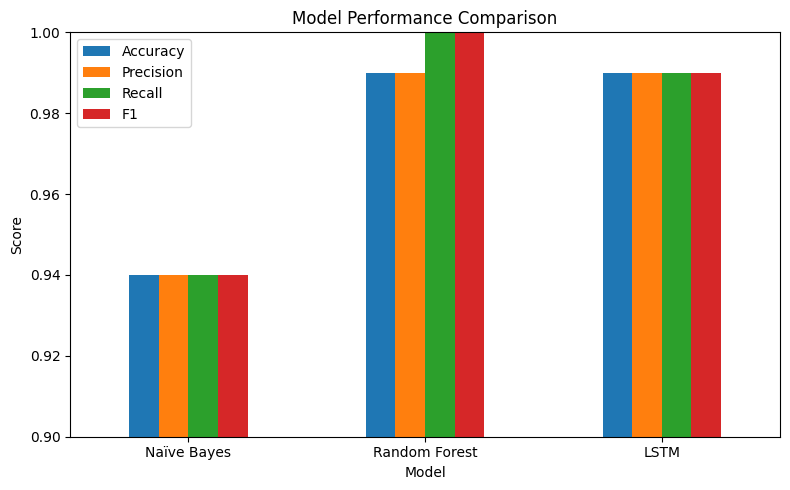

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Build a DataFrame with the final metrics

results = pd.DataFrame({
    'Model': ['Naïve Bayes', 'Random Forest', 'LSTM'],
    'Accuracy': [0.94, 0.99, 0.99],
    'Precision': [0.94, 0.99, 0.99],
    'Recall': [0.94, 1.00, 0.99],
    'F1': [0.94, 1.00, 0.99]
}).set_index('Model')

# Display the table

print(results)

# Plot the bar chart

results.plot.bar(rot=0, figsize=(8,5))
plt.ylim(0.9, 1.0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.tight_layout()
plt.show()
